In [ ]:
#import libraries
import numpy as np
import tensorflow as tf
from tensorflow import keras
import pandas as pd
from tqdm import tqdm
import re

from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.utils import np_utils
from keras.models import Sequential
from keras.layers import Embedding, Flatten, Dense, LSTM, Bidirectional, Conv1D, MaxPooling1D
from tensorflow.keras import optimizers
from sklearn.preprocessing import LabelBinarizer
from sklearn.utils import class_weight


In [ ]:
#importing dataset
tqdm.pandas()
df = pd.read_excel('/dataset/annotated_reviews.xlsx')
df.drop(['Unnamed: 0'],axis = 1, inplace = True)
df = df.sample(frac = 1).reset_index(drop=True)

In [ ]:
df.dropna(inplace=True)
df["category"].value_counts()

positive    3051
negative    2585
neutral      905
Name: category, dtype: int64

In [ ]:
# utility function to build custom vocabulary of our dataset

def build_vocab(sentences, verbose =  True):
    """
    :param sentences: list of list of words
    :return: dictionary of words and their count
    """
    vocab = {}
    for sentence in tqdm(sentences, disable = (not verbose)):
        for word in sentence:
            try:
                vocab[word] += 1
            except KeyError:
                vocab[word] = 1
    return vocab

In [ ]:
#Running for only for only pos and neg category, dont run this part if u want to include neutral.
df = df.loc[df["category"]!='neutral']
df["category"].value_counts()

positive    3051
negative    2585
Name: category, dtype: int64

In [ ]:
sentences = df["review"].apply(str).progress_apply(lambda x: x.split()).values
vocab = build_vocab(sentences)
print({k: vocab[k] for k in list(vocab)[:5]})

100%|██████████| 5636/5636 [00:00<00:00, 34846.75it/s]

{'যারা': 485, 'ছোট': 312, 'বেলায়': 13, 'ক্রিকেট': 32, 'খেলছেন।এই': 1}


In [ ]:
# loading fasttext word embedding matrix
# The embedding matrix can be found in the link provided. 
# Download the 300 dimensional bengali embeddingmatrix and save it in the current working directory.
# https://fasttext.cc/docs/en/crawl-vectors.html

fasttext_dir = 'cc.bn.300.vec'
embeddings_index = {}
import numpy as np
import io
def load_vectors(fname):
    fin = io.open(fname, 'r', encoding='utf-8', newline='\n', errors='ignore')
    n, d = map(int, fin.readline().split())
    data = {}
    for line in fin:
        tokens = line.rstrip().split(' ')
        data[tokens[0]] = np.asarray(tokens[1:], dtype='float32')
        #data[tokens[0]] = map(float, tokens[1:])
    return data
 
embeddings_index = load_vectors(fasttext_dir)

In [ ]:
# utility function to determines the percentage of vocabulary exists in the embedding matrix
#It will output a list of out of vocabulary (oov) words
#that we can use to improve our preprocessing
import operator 
 
def check_coverage(vocab,embeddings_index):
    a = {}
    oov = {}
    k = 0
    i = 0
    for word in tqdm(vocab):
        try:
            a[word] = embeddings_index[word]
            k += vocab[word]
        except:
 
            oov[word] = vocab[word]
            i += vocab[word]
            pass
 
    print('Found embeddings for {:.2%} of vocab'.format(len(a) / len(vocab)))
    print('Found embeddings for  {:.2%} of all text'.format(k / (k + i)))
    sorted_x = sorted(oov.items(), key=operator.itemgetter(1))[::-1]
 
    return sorted_x

In [ ]:
#out of vocabulary words
#initial: 53.21% of vocab, 85.59% of all text
oov = check_coverage(vocab,embeddings_index)

100%|██████████| 71166/71166 [00:00<00:00, 755981.76it/s]

Found embeddings for 53.36% of vocab
Found embeddings for  84.81% of all text


In [ ]:
oov[:20]

[('না।', 1905),
 ('হয়েছে।', 785),
 ('বই।', 716),
 ('যায়।', 627),
 ('হয়।', 620),
 ('করে।', 566),
 ('আছে।', 492),
 ('না,', 464),
 ('হবে।', 451),
 ('নেই।', 451),
 ('নয়।', 366),
 ('করেছেন।', 357),
 ('জন্য।', 347),
 ('লেগেছে।', 328),
 ('থাকে।', 315),
 ('ছিল।', 312),
 ('পারে।', 298),
 ('করেন।', 281),
 ('উপন্যাস।', 239),
 ('যে,', 223)]

In [ ]:
# utility function to clean text, ommiting every character other than bangla alphabet and numbers
def clean_text(x):
    pattern = r'[^ঁ-৯\s]'
    x = re.sub(pattern, '', x)
    return x

In [ ]:
# Modifying stopword list

f = open("stop_words.txt","r")
stopwords_list = f.read().split('\n')
stopwords_list_extend = ['রকমারি','বুক','বইটি','বই','বইটা','বইটিতে','#রকমারি_বইপোকা_রিভিউ_প্রতিযোগিতা','রকমারি_বইপোকা_রিভিউ_প্রতিযোগিতা','উপন্যাস','উপন্যাসটা','উপন্যাসটি','যে','তা','পাঠপ্রতিক্রিয়াঃ','রকমারিরিভিউপ্রতিযোগমার্চ']
remove_list =['অবশ্য','যথেষ্ট','নয়','না','নেই','বাদে','যদিও','যত','যতটা']
for t in remove_list:
  stopwords_list.remove(t)
stopwords_list.extend(stopwords_list_extend)
f.close()

In [ ]:
# utility function to remove stopwords

def removing_stopwords(text):
  words = text.split(' ')
  words_without_stopwords = [word for word in words if not word in stopwords_list]
  filtered_Txt = " ".join(words_without_stopwords)
  return filtered_Txt

In [ ]:
# cleaning text and removing stopwords

df["review"] = df["review"].apply(str).apply(removing_stopwords)
df["review"] = df["review"].apply(str).apply(clean_text)

In [ ]:
#after some preprocessing 75.95% of vocab, 95.14% of all text

sentences = df["review"].progress_apply(lambda x: x.split()).values
vocab = build_vocab(sentences)
oov = check_coverage(vocab,embeddings_index)

100%|██████████| 51291/51291 [00:00<00:00, 782092.00it/s]

Found embeddings for 75.99% of vocab
Found embeddings for  95.29% of all text


In [ ]:
# seeing the top 20 wordcount of reviews in our dataset
df["review"].apply(lambda x: len(x.split())).nlargest(20)

444     2148
3303    1167
1071    1097
1634    1041
1114    1004
4533     945
898      918
5383     886
3582     879
942      865
475      860
5802     801
963      784
1290     772
3137     765
1179     715
5939     698
1541     688
3078     684
4511     680
Name: review, dtype: int64

In [ ]:
#selecting reviews with length less than n=300
df = df[df['review'].apply(lambda x: len(x.split()) <= 300)] #450

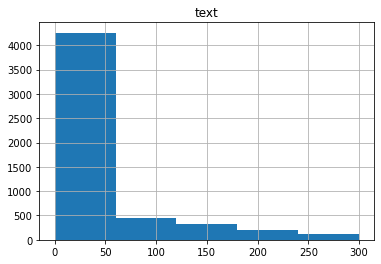

In [ ]:
#Here, we will analyze the length of the reviews and the summary to get an overall idea about the distribution of length of the text.
#This will help us fix the maximum length of the sequence:
 
import matplotlib.pyplot as plt
text_word_count = []
 
# populate the lists with sentence lengths
for i in df['review']:
      text_word_count.append(len(i.split()))
 
length_df = pd.DataFrame({'text':text_word_count})
length_df.hist(bins=5)
plt.show()

In [ ]:
#for finding the largest lentence length in the dataset
maxlenfind=length_df.nlargest(1,columns="text")["text"].tolist()[0]
print(maxlenfind)

300


In [ ]:
# Converting relevant column of dataframe into list
reviews_text = list(df["review"].apply(str))
categories = list(df["category"].apply(str))
ratings = list(df["rating"].apply(int))
maxlen = maxlenfind

#Tokenizing the reviews
tokenizer = Tokenizer() #num_words=max_words
tokenizer.fit_on_texts(reviews_text)
sequences = tokenizer.texts_to_sequences(reviews_text)
word_index = tokenizer.word_index
print('Found %s unique tokens.' % len(word_index))
data = pad_sequences(sequences, maxlen=maxlen)

# binarizing the categories
label = LabelBinarizer().fit_transform(categories)
ratings_encoded = np_utils.to_categorical(df["rating"])
 
print('Shape of data tensor:', data.shape)
print('Shape of label tensor:', label.shape)
print('shape of rating tensor: ',ratings_encoded.shape)

Found 39299 unique tokens.
Shape of data tensor: (5369, 300)
Shape of label tensor: (5369, 1)
shape of rating tensor:  (5369, 6)


In [ ]:
#deviding dataset into train, validation and test data
x_train = data[0:-536] #for length above 250 choose 5200
y_train = label[0:-536] 
ratings_train = ratings_encoded[0:-536]
 
x_test = data[-536:] 
y_test = label[-536:] 
ratings_test = ratings_encoded[-536:]

In [ ]:
# Converting raw text into vector using embedding matrix

max_words = max([max(sequence) for sequence in data])+1
embedding_dim = 300
embedding_matrix = np.zeros((max_words, embedding_dim))
for word, i in word_index.items():
  if i < max_words:
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
      embedding_matrix[i] = embedding_vector

In [ ]:
# Model architecture for LSTM/BiLSTM model 
# Comment or Uncomment to train a specific model


model = Sequential()
model.add(Embedding(max_words, embedding_dim, input_length=maxlen))
#model.add(LSTM(128))
model.add(Bidirectional(LSTM(128)))
model.add(Dense(64, activation='relu'))
model.add(Dense(1, activation='sigmoid')) # use softmax for 3 category including neutral and last layer size 3

model.layers[0].set_weights([embedding_matrix])
model.layers[0].trainable = False
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, 300, 300)          11790000  
_________________________________________________________________
bidirectional_1 (Bidirection (None, 256)               439296    
_________________________________________________________________
dense_4 (Dense)              (None, 64)                16448     
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 65        
Total params: 12,245,809
Trainable params: 455,809
Non-trainable params: 11,790,000
_________________________________________________________________


In [ ]:
# Model architecture for LSTM-CNN model 


model_LSTM_CNN = Sequential()
model_LSTM_CNN.add(Embedding(max_words, embedding_dim, input_length=maxlen))
model_LSTM_CNN.add(Conv1D(32, 5, activation='relu'))
model_LSTM_CNN.add(MaxPooling1D(3))
model_LSTM_CNN.add(LSTM(128))
#model_LSTM_CNN.add(Dense(32, activation='relu'))
model_LSTM_CNN.add(Dense(1, activation='sigmoid')) # use softmax for 3 category including neutral and last layer size 3
 
model_LSTM_CNN.layers[0].set_weights([embedding_matrix])
model_LSTM_CNN.layers[0].trainable = False
model_LSTM_CNN.summary()

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_7 (Embedding)      (None, 300, 300)          11790000  
_________________________________________________________________
conv1d_4 (Conv1D)            (None, 296, 32)           48032     
_________________________________________________________________
max_pooling1d_4 (MaxPooling1 (None, 98, 32)            0         
_________________________________________________________________
lstm_7 (LSTM)                (None, 128)               82432     
_________________________________________________________________
dense_10 (Dense)             (None, 1)                 129       
Total params: 11,920,593
Trainable params: 130,593
Non-trainable params: 11,790,000
_________________________________________________________________


In [ ]:
# Model architecture for BiLSTM-CNN model 

model_BiLSTM_CNN = Sequential()
model_BiLSTM_CNN.add(Embedding(max_words, embedding_dim, input_length=maxlen))
#model.add(Flatten())
model_BiLSTM_CNN.add(Conv1D(32, 3, activation='relu')) #3
model_BiLSTM_CNN.add(MaxPooling1D(3))
model_BiLSTM_CNN.add(Bidirectional(LSTM(128)))
#model_BiLSTM_CNN.add(Dense(64, activation='relu'))
model_BiLSTM_CNN.add(Dense(1, activation='sigmoid')) # use softmax for 3 category including neutral and last layer size 3
 
model_BiLSTM_CNN.layers[0].set_weights([embedding_matrix])
model_BiLSTM_CNN.layers[0].trainable = False
model_BiLSTM_CNN.summary()

Model: "sequential_14"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_14 (Embedding)     (None, 300, 300)          11790000  
_________________________________________________________________
conv1d_11 (Conv1D)           (None, 298, 32)           28832     
_________________________________________________________________
max_pooling1d_11 (MaxPooling (None, 99, 32)            0         
_________________________________________________________________
bidirectional_8 (Bidirection (None, 256)               164864    
_________________________________________________________________
dense_17 (Dense)             (None, 1)                 257       
Total params: 11,983,953
Trainable params: 193,953
Non-trainable params: 11,790,000
_________________________________________________________________


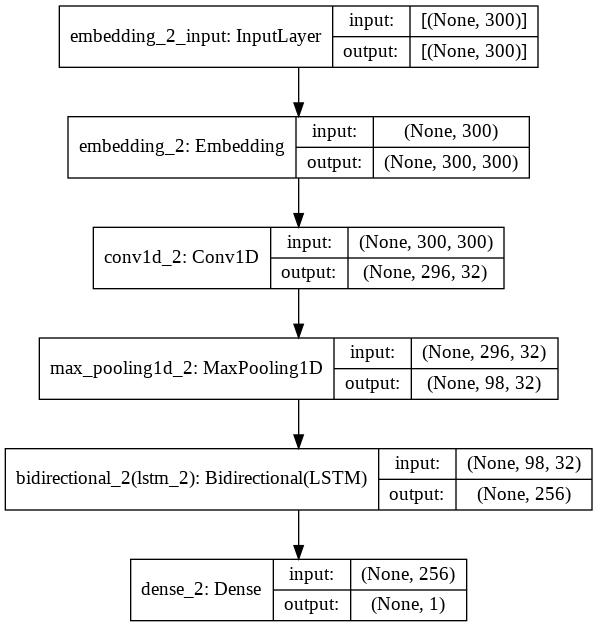

In [ ]:
# Plotting the model

keras.utils.plot_model(model_BiLSTM_CNN, "images/bilstm_cnn.png", show_shapes=True)

In [ ]:
# Computing class weights to defend class imbalance
wghts = class_weight.compute_class_weight('balanced', np.unique(categories), categories)
wghts_dict = dict(enumerate(wghts))

In [ ]:
#callbacks=[tf.keras.callbacks.EarlyStopping('val_loss', patience=3)]
model_BiLSTM_CNN.compile(optimizer=optimizers.Adam(learning_rate=0.0002),loss='binary_crossentropy',metrics=['acc']) 
history = model_BiLSTM_CNN.fit(x_train, y_train, epochs=10, batch_size=32,validation_split = 0.2,class_weight=wghts_dict)
model_BiLSTM_CNN.save_weights("bilstm_cnn.h5")
 
 
# for LSTM_CNN
#model_LSTM_CNN.compile(optimizer=optimizers.RMSprop(learning_rate=0.0002),loss='binary_crossentropy',metrics=['acc']) 
#history = model_LSTM_CNN.fit(x_train, y_train,epochs=10,batch_size=32,validation_split = 0.2,class_weight=wghts_dict)
#model_LSTM_CNN.save_weights('lstm_cnn.h5')
 
# for biLstm
#model.set_weights('/content/drive/MyDrive/colabworks/BooksReview/models/model_before_training.h5')
#model.compile(optimizer=optimizers.RMSprop(learning_rate=0.0002),loss='binary_crossentropy',metrics=['acc']) 
#history = model.fit(x_train, y_train,epochs=5,batch_size=32,validation_split=0.2,class_weight=wghts_dict)
#model.save_weights('bilstm.h5')

Epoch 1/10
121/121 [==============================] - 12s 68ms/step - loss: 0.6061 - acc: 0.6570 - val_loss: 0.5331 - val_acc: 0.7611
Epoch 2/10
121/121 [==============================] - 7s 59ms/step - loss: 0.5489 - acc: 0.7315 - val_loss: 0.5038 - val_acc: 0.7777
Epoch 3/10
121/121 [==============================] - 7s 58ms/step - loss: 0.5222 - acc: 0.7486 - val_loss: 0.4684 - val_acc: 0.7890
Epoch 4/10
121/121 [==============================] - 7s 55ms/step - loss: 0.4889 - acc: 0.7755 - val_loss: 0.4543 - val_acc: 0.8087
Epoch 5/10
121/121 [==============================] - 7s 54ms/step - loss: 0.4672 - acc: 0.7887 - val_loss: 0.4262 - val_acc: 0.8128
Epoch 6/10
121/121 [==============================] - 6s 52ms/step - loss: 0.4474 - acc: 0.7982 - val_loss: 0.4152 - val_acc: 0.8170
Epoch 7/10
121/121 [==============================] - 6s 50ms/step - loss: 0.4316 - acc: 0.8068 - val_loss: 0.4114 - val_acc: 0.8190
Epoch 8/10
121/121 [==============================] - 6s 50ms/step -

In [ ]:
# to load model from checkpoint
#model_LSTM_CNN.load_weights('bilstm_cnn.h5')

In [ ]:
# Evaluating model performance on test data

# for bi_lstm
#model.evaluate(x_test, y_test)
 
# for LSTM_CNN
#model_LSTM_CNN.evaluate(x_test,y_test)
 
# for BiLSTM_CNN
model_BiLSTM_CNN.evaluate(x_test,y_test)

17/17 [==============================] - 0s 21ms/step - loss: 0.4359 - acc: 0.8209


[0.4359288215637207, 0.8208954930305481]

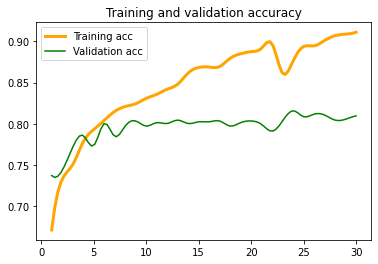

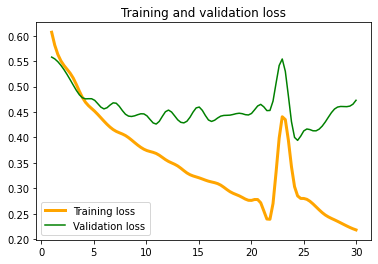

In [ ]:
#ploting the results
import matplotlib.pyplot as plt
from scipy import interpolate
epochs_new = np.linspace(1,30,100)
epochs = range(30)

acc = history.history['acc']
epochs = range(1, len(acc) + 1)
smoothAcc = interpolate.make_interp_spline(epochs, acc)
AccNew=smoothAcc(epochs_new)

val_acc = history.history['val_acc']
smoothValAcc = interpolate.make_interp_spline(epochs, val_acc)
AccValNew=smoothValAcc(epochs_new)


loss = history.history['loss']
smoothLoss = interpolate.make_interp_spline(epochs, loss)
LossNew=smoothLoss(epochs_new)


val_loss = history.history['val_loss']
smoothValLoss = interpolate.make_interp_spline(epochs, val_loss)
LossValNew=smoothValLoss(epochs_new)


epochs = range(1, len(acc) + 1)
plt.plot(epochs_new, AccNew, '-', lineWidth = '3', color="orange", label='Training acc')
plt.plot(epochs_new, AccValNew, 'g', label='Validation acc')
#plt.plot(epochs, acc,'o',color ="orange")
#plt.plot(epochs,val_acc,'go')
plt.title('Training and validation accuracy')
plt.legend()
plt.figure()
plt.plot(epochs_new, LossNew, '-', lineWidth='3', color ="orange", label='Training loss')
plt.plot(epochs_new, LossValNew, 'g', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.savefig('images/bilstm_cnn_losscurve.jpeg',dpi =500)
plt.show()

In [ ]:
pred = model_BiLSTM_CNN.predict(x_test)

In [ ]:
# Checking if our model can predict the first 10 samples of test data

print(y_test[:10])
print(pred[:10])

[[0]
 [1]
 [1]
 [1]
 [1]
 [0]
 [1]
 [1]
 [0]
 [0]]
[[0.00232719]
 [0.93704337]
 [0.5996779 ]
 [0.7645317 ]
 [0.7679169 ]
 [0.09992055]
 [0.7481935 ]
 [0.12015433]
 [0.35710737]
 [0.9233736 ]]


[[233  26]
 [ 70 207]]
              precision    recall  f1-score   support

    negative     0.7690    0.8996    0.8292       259
    positive     0.8884    0.7473    0.8118       277

    accuracy                         0.8209       536
   macro avg     0.8287    0.8235    0.8205       536
weighted avg     0.8307    0.8209    0.8202       536



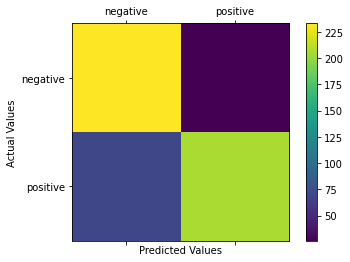

In [ ]:
#for binary
import warnings
import pandas as pd
from sklearn import model_selection
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt
%matplotlib inline  

#ignore warnings
warnings.filterwarnings('ignore')
#pred = model.predict([x_test,ratings_test])
pred = model_BiLSTM_CNN.predict(x_test)

#Construct the Confusion Matrix
labels = ['negative','positive']
cm = confusion_matrix(y_test, pred.round())
#cm = confusion_matrix(y_test, pred)
report = classification_report(y_test,pred.round(), digits=4, labels= [0,1], target_names=labels)
print(cm)
print(report)
fig = plt.figure()
ax = fig.add_subplot(111)
cax = ax.matshow(cm)
#plt.title('Confusion matrix')
fig.colorbar(cax)
ax.set_xticklabels([''] + labels)
ax.set_yticklabels([''] + labels)
plt.xlabel('Predicted Values')
plt.ylabel('Actual Values')
plt.show()
#plt.savefig('cm_cnn_bilstm.jpeg',dpi = 500)